In [280]:
#Import delle librerie
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn as sk
import seaborn as sns
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, recall_score, precision_score, f1_score, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from scipy.stats import loguniform, randint # Fondamentale per le distribuzioni
from sklearn.model_selection import RandomizedSearchCV
import math
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.base import clone

In [281]:
# si importa il dataset ionosphere da openml
ionosphere = sk.datasets.fetch_openml(name = "ionosphere")

# si crea il dataframe
df_ionosphere = pd.DataFrame(data = ionosphere.data, columns = ionosphere.feature_names)

# si aggiunge la colonna delle etichette di classe
class_labels = pd.Series(ionosphere.target, name = "class")

# si concatena la colonna delle etichette al dataframe
df_ionosphere = pd.concat([df_ionosphere, class_labels], axis = 1)

# si visualizzano le prime righe del dataframe
df_ionosphere.head()

,a01,a02,a03,a04,a05,a06,a07,a08,a09,a10,...,a26,a27,a28,a29,a30,a31,a32,a33,a34,class
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g


In [282]:
print(ionosphere.DESCR)

**Author**: Space Physics Group, Applied Physics Laboratory, Johns Hopkins University. Donated by Vince Sigillito.  
**Source**: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/ionosphere)  
**Please cite**: [UCI](https://archive.ics.uci.edu/ml/citation_policy.html) 

**Johns Hopkins University Ionosphere database**  
This radar data was collected by a system in Goose Bay, Labrador.  This system consists of a phased array of 16 high-frequency antennas with a total transmitted power on the order of 6.4 kilowatts.  See the paper for more details.  

### Attribute information
Received signals were processed using an autocorrelation function whose arguments are the time of a pulse and the pulse number.  There were 17 pulse numbers for the Goose Bay system.  Instances in this database are described by 2 attributes per pulse number, corresponding to the complex values returned by the function resulting from the complex electromagnetic signal.

The targets were free 

# INIZIO ANALISI DEL DATASET
#### Cosa rappresentano queste feature?

Questi dati radar sono stati presi da un sistema di 16 antenne ad alta frequenza situato a Labrador, Goose Bay.
Lo scopo di questo sistema è studiare la fisica della ionosfera. La ionosfera è uno strato dell'atomosfera terrestre situata tra i 50 e i 700 km di altitudine. Nella ionosfera i raggi X ad alta energia e gli UV collidono con le molecole di gas ionizzandole. Questo processo consiste nello staccare un elettrone o più dalla molecola di gas, creando una coppia elettrone/ione positivo. Questa parte dell'atomosfera ha una grande quantità di elettroni liberi (non legati a nessuna molecola).

Lo scopo di queste 16 antenne è sparare impulsi radio verso la ionosfera e "ascoltare" gli echi che tornano indietro. Questi echi sono riflessi dai "bersagli", che in questo caso sono gli elettroni liberi presenti nella ionosfera.

Il segnale ricevuto dall'antenna (eco degli elettroni liberi) è una funzione complessa, contiene una parte immaginaria e una reale.

Per analizzare il segnale, il sistema non usa i dati grezzi ma calcola la funzione di autocorrelazione. Questa funzione, in pratica, misura quanto il segnale è simile a sé stesso in diversi momenti. Il numero di momenti successivi per cui viene calcolata questa funzione è 17.

Il segnale è complesso, quindi per ogni momento successivo in cui si calcola la ACF si ha una parte reale e una immaginaria. Quindi, i momenti successivi sono 17, allora il numero di risultati sarà 34 (numero delle feature).
Quindi le feature di questo dataset sono le parti reali e immaginarie della funzione di autocorrelazione calcolata in 17 momenti successivi rispetto al primo.

Il sistema radar genera 25 di queste 17 coppie di numeri ogni 5 secondi per tutto un anno (molti). Quindi, ci sono molti segnali che possono essere brutti o buoni.

I valori delle feature sono già normalizzati nell'intervallo [-1, +1].

I risultati buoni indicano la presenza di una struttura nella ionosfera. I risultati brutti possono essere causati da diversi fattori: il segnale non rimbalza da nessuna parte quindi va fuori dalla ionosfera (nessuna struttura), il segnale rimbalza in troppe strutture e quindi si cancella/attenua troppo, assorbimento degli impulsi radar oppure da interferenza con altri trasmettitori. Quindi i segnali brutti sono più variegati rispetto a quelli buoni.


Cosa vogliono dire i valori [-1, 1]?

Se il valore è uguale a 1 allora si ha perfetta correlazione tra il segnale all'inizio e quello all'istante k successivo (sono identici).
Se il valore è uguale a 0 allora non si ha correlazione tra i due segnali (sono completamente diversi, scorrelati, statisticamente indipendenti)
Se il valore è uguale a -1 allora si ha perfetta anticorrelazione, ovvero il segnale è specchiato perfettamente.

I segnale buoni (presenza di struttura) hanno dei valori di ACF che non cambiano troppo velocemente durante quei 17 momenti successivi. I segnali cattivi hanno valori di ACF super casuali (oscillano intorno allo zero praticamente).

### Si mostrano dei grafici delle ACF

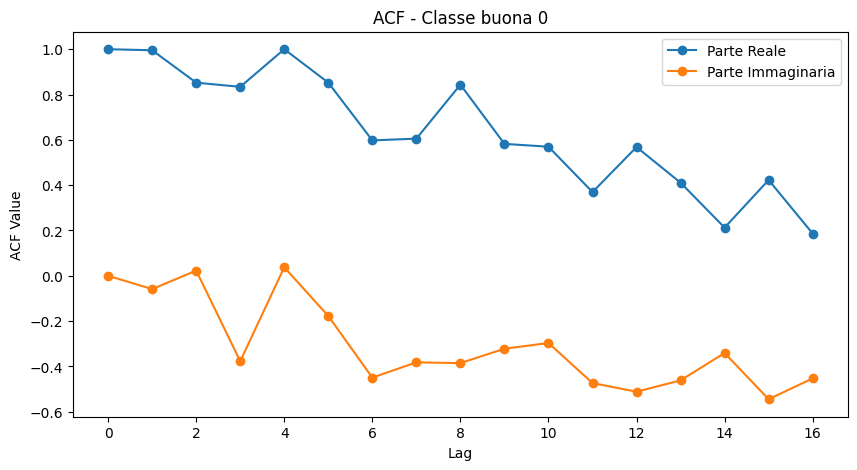

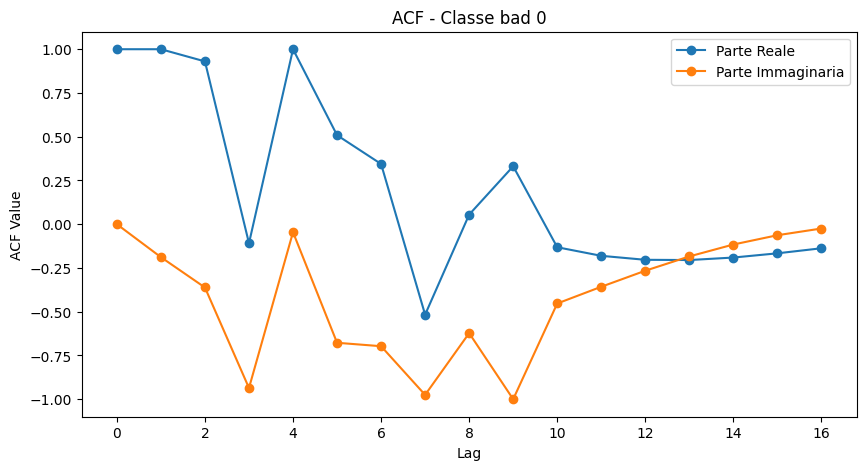

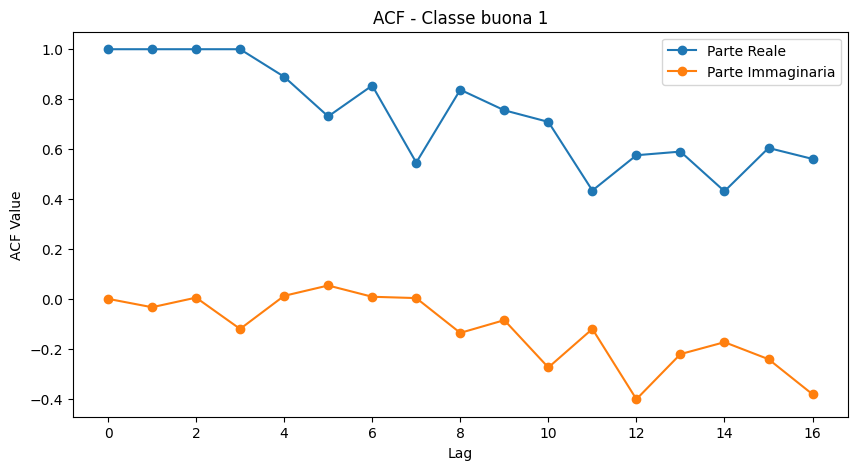

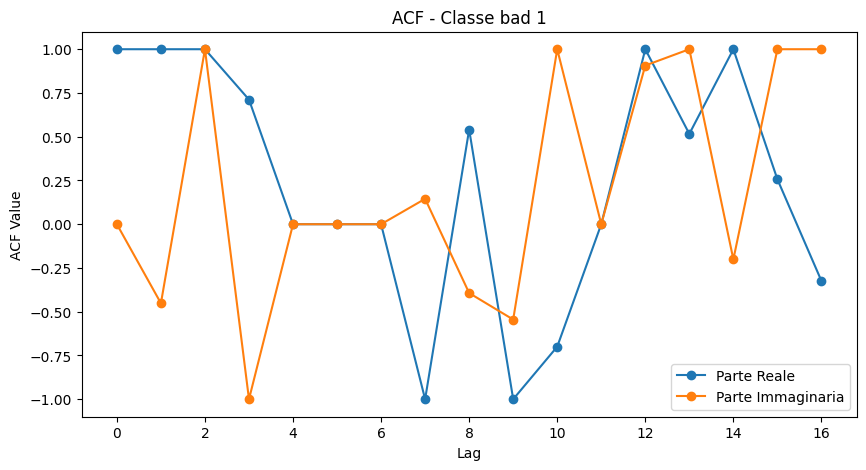

In [283]:
# estraggo le prime due righe di ciascuna classe
righe_good = df_ionosphere[df_ionosphere['class'] == 'g'].head(2).values
righe_bad = df_ionosphere[df_ionosphere['class'] == 'b'].head(2).values

# estraggo i primi 34 valori di ciascuna riga, eliminando l'etichetta di classe
riga_good_0 = righe_good[0][0:34]
riga_bad_0 = righe_bad[0][0:34]
riga_good_1 = righe_good[1][0:34]
riga_bad_1 = righe_bad[1][0:34]

# separo le feature che rappresenta la parte immaginaria e reale della acf
riga_good_0_reale = riga_good_0[0::2]
riga_good_0_immaginario = riga_good_0[1::2]
riga_bad_0_reale = riga_bad_0[0::2]
riga_bad_0_immaginario = riga_bad_0[1::2]

riga_good_1_reale = riga_good_1[0::2]
riga_good_1_immaginario = riga_good_1[1::2]
riga_bad_1_reale = riga_bad_1[0::2]
riga_bad_1_immaginario = riga_bad_1[1::2]


# grafico acf 0 good
plt.figure(figsize=(10, 5))
plt.plot(riga_good_0_reale, label='Parte Reale', marker='o')
plt.plot(riga_good_0_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe buona 0')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()

# grafico acf 0 bad
plt.figure(figsize=(10, 5))
plt.plot(riga_bad_0_reale, label='Parte Reale', marker='o')
plt.plot(riga_bad_0_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe bad 0')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()

# grafico acf 1 good
plt.figure(figsize=(10, 5))
plt.plot(riga_good_1_reale, label='Parte Reale', marker='o')
plt.plot(riga_good_1_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe buona 1')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()

# grafico acf 1 bad
plt.figure(figsize=(10, 5))
plt.plot(riga_bad_1_reale, label='Parte Reale', marker='o')
plt.plot(riga_bad_1_immaginario, label='Parte Immaginaria', marker='o')
plt.title('ACF - Classe bad 1')
plt.xlabel('Lag')
plt.ylabel('ACF Value')
plt.legend()
plt.show()

### Grafico a torta per capire come sono distribuite le classi

Text(0.5, 1.0, 'Distribuzione delle classi nel dataset Ionosphere')

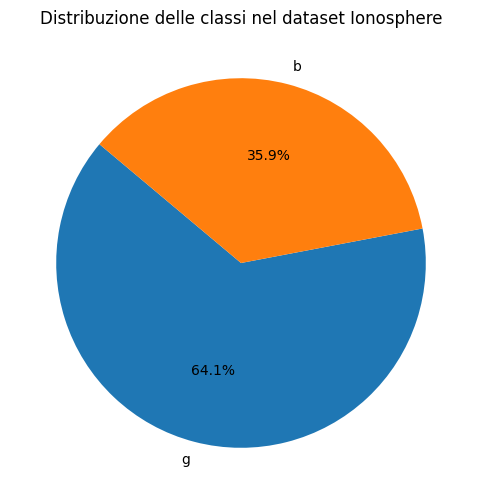

In [284]:
#### Grafico a torta per capire come sono distribuite le classi
class_counts = df_ionosphere['class'].value_counts()
labels = class_counts.index
sizes = class_counts.values
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribuzione delle classi nel dataset Ionosphere') 

# Distribuzione delle feature differenziate per classi

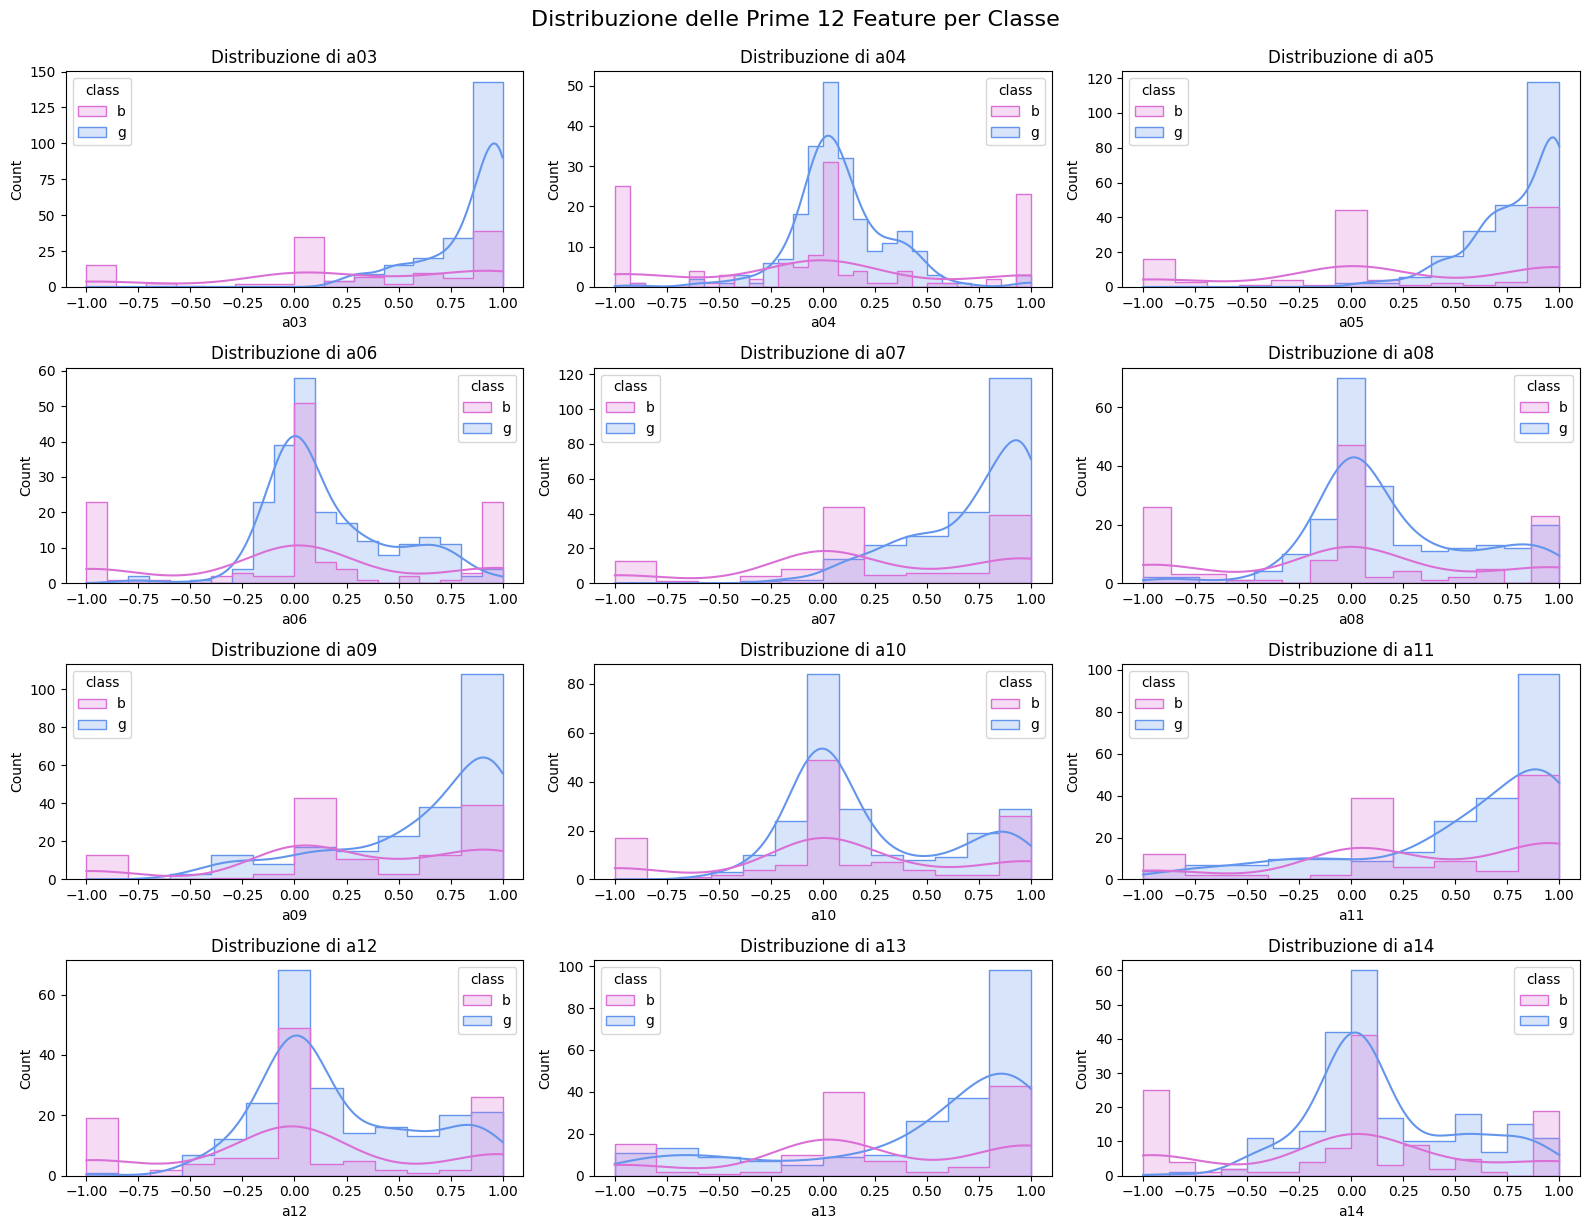

In [285]:
# Prime 12 feature
class_map = {'g': 'Good signal', 'b': 'Bad signal'}
color_map_dict = {'g': 'cornflowerblue', 'b': 'orchid'}
feature_column_names = ionosphere.feature_names

features_to_plot = feature_column_names[2:14]

# Costruisci la palette 
palette = {label: color for label, color in color_map_dict.items()}

plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.histplot(
        df_ionosphere,
        x=feature,
        hue='class',
        kde=True,
        palette=palette,
        element='step'
    )
    plt.title(f'Distribuzione di {feature}')

plt.tight_layout()
plt.suptitle('Distribuzione delle Prime 12 Feature per Classe', y=1.02, fontsize=16)
plt.show()

Dall'analisi grafica delle distribuzioni emerge innanzitutto che i dati sono già normalizzati nell'intervallo tra -1 e +1, il che conferma l'assenza di necessità di ulteriori scalature, ma l'aspetto più rilevante è la netta dicotomia strutturale tra le feature con indice dispari e quelle con indice pari. 

Osservando le feature dispari, come a03, a05 o a07, si nota chiaramente che la classe "good" (in blu) tende a concentrarsi in modo massiccio verso il valore +1, evidenziando un segnale forte e coerente, mentre la classe "bad" (in rosa) risulta dispersa quasi uniformemente su tutto il range, comportandosi sostanzialmente come rumore di fondo; la feature a03, in particolare, appare come un predittore estremamente potente poiché la classe positiva è quasi interamente schiacciata sul valore massimo. Al contrario, le feature pari mostrano entrambe le classi centrate attorno allo zero, distinguendosi però per la varianza: la classe "good" forma una campana stretta e molto definita, mentre la "bad" è decisamente più larga e appiattita. 

In sintesi, queste visualizzazioni raccontano la storia di un dataset dove la classe positiva ha una firma strutturale densa e riconoscibile contro il comportamento caotico della classe negativa, una caratteristica che renderà il compito di classificazione particolarmente agevole per algoritmi capaci di sfruttare sia i tagli sui valori, come gli alberi decisionali, sia la densità dei punti, come le SVM o il KNN.

### Matrice di correlazione tra le feature

Text(0.5, 1.0, "Matrice di Correlazione delle Feature dell'Ionosphere Dataset")

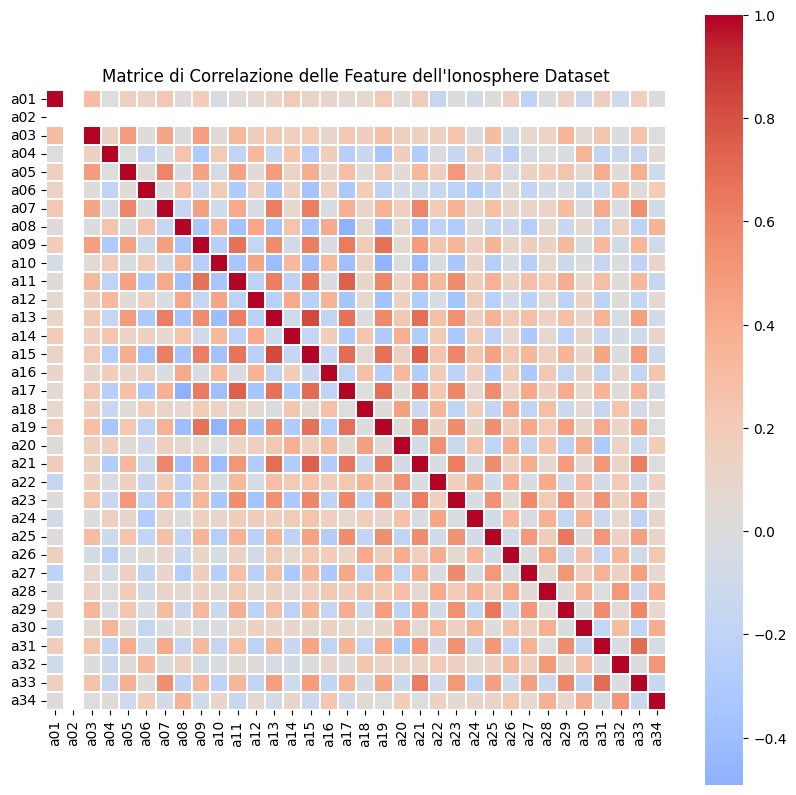

In [286]:
# Matrice di correlazione
plt.figure(figsize=(10, 10))
correlation_matrix = df_ionosphere.iloc[:, :-1].corr(method='pearson')  # Escludi la colonna delle etichette di classe
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True, center=0, linewidths=0.3)
plt.title('Matrice di Correlazione delle Feature dell\'Ionosphere Dataset')

### Box plot delle feature

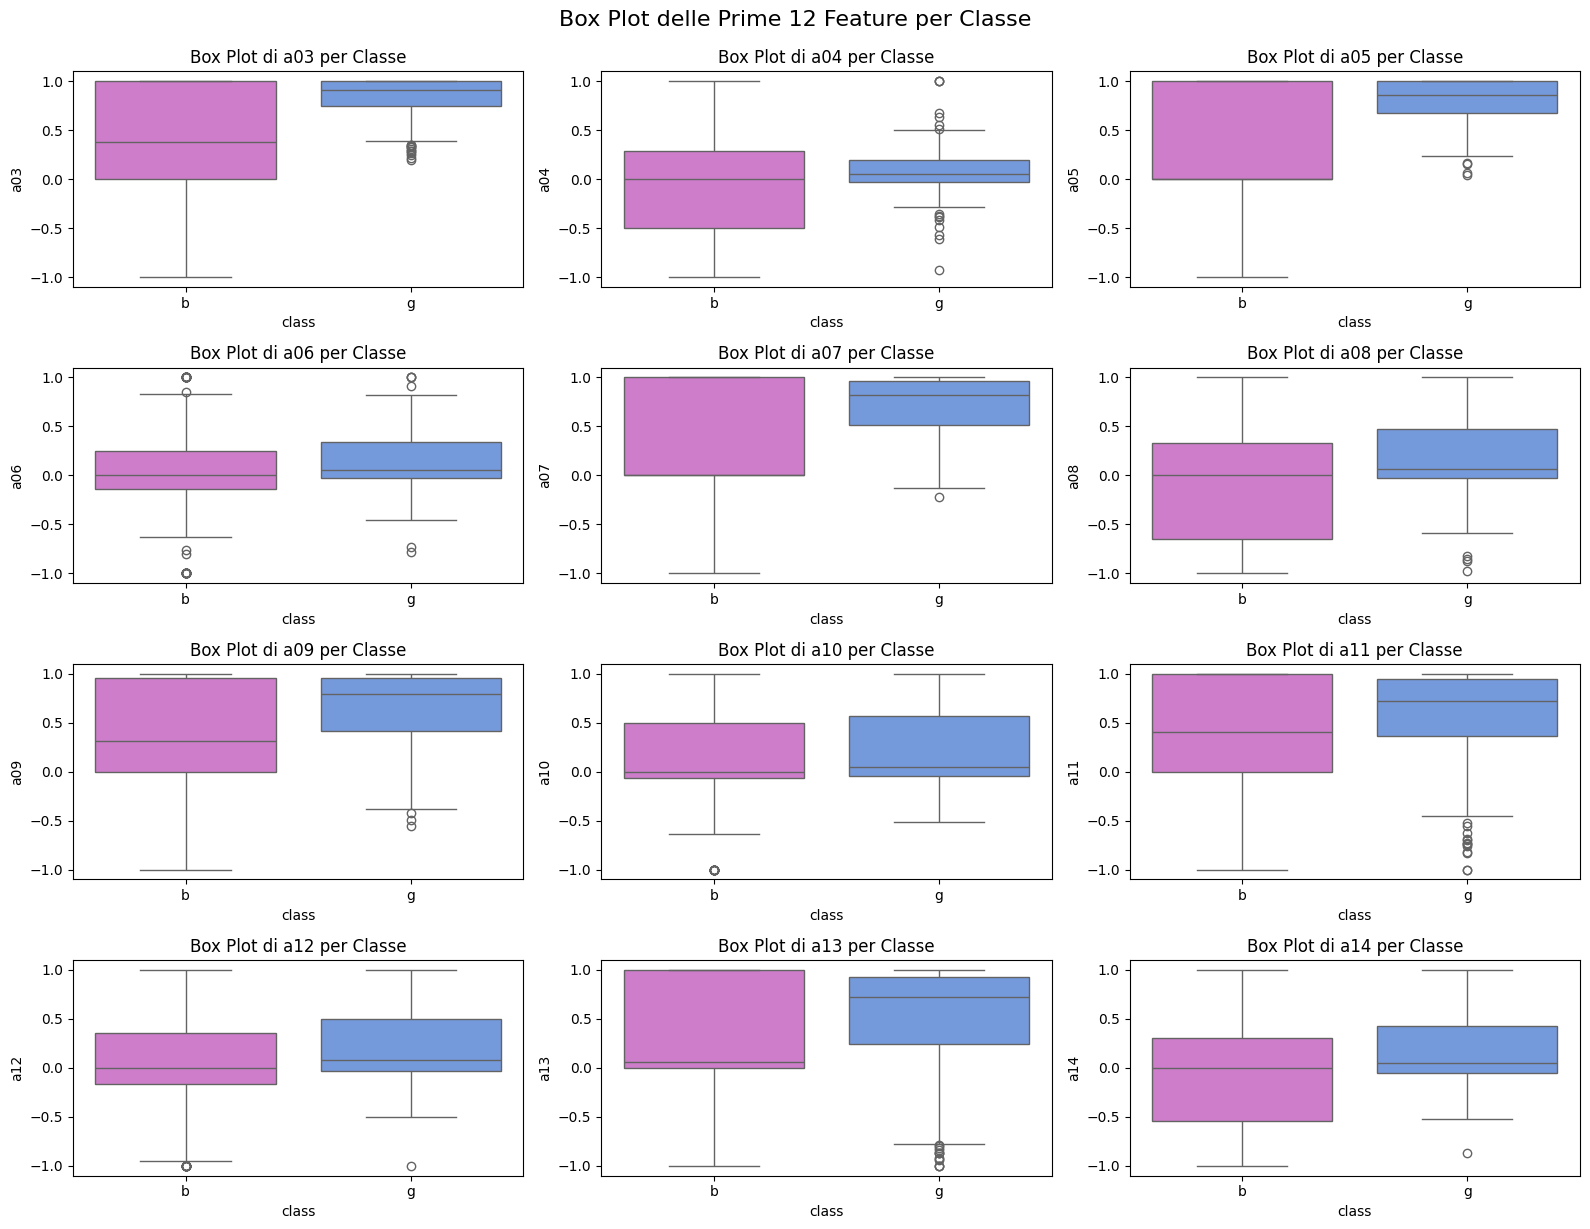

In [287]:
# Box plot delle feature
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_to_plot):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(
        data=df_ionosphere,
        x='class',
        y=feature,
        palette=palette,
        hue='class'
    )
    plt.title(f'Box Plot di {feature} per Classe')
plt.tight_layout()
plt.suptitle('Box Plot delle Prime 12 Feature per Classe', y=1.02, fontsize=16)
plt.show()

### Parallel coordinates plot

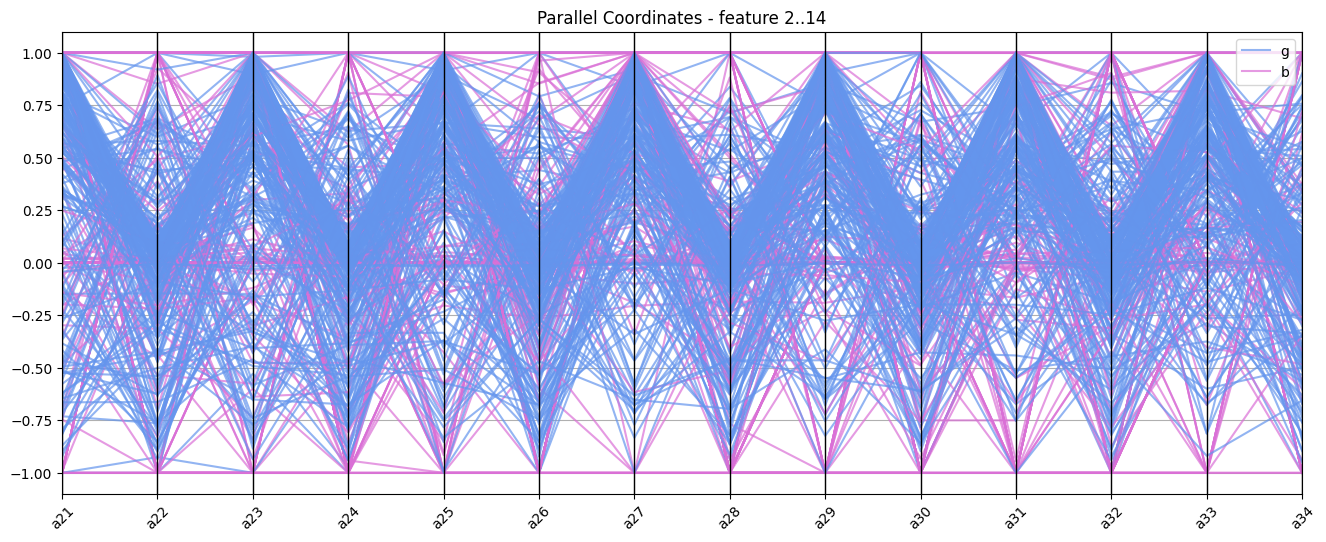

In [288]:
# Coordinate parallele solo dalle feature
feature_column_names = ionosphere.feature_names

features_to_plot = feature_column_names[20:34]
cols = features_to_plot
plt.figure(figsize=(16, 6))
colors = [palette[label] for label in labels]  # palette e labels esistenti
parallel_coordinates(df_ionosphere[cols + ['class']], 'class', color=colors, alpha=0.7)
plt.title('Parallel Coordinates - feature 2..14')
plt.xticks(rotation=45)
plt.show()

Si nota che andando avanti con le feature i dati diventano più rumorosi. Questo è ragionevole perchè il segnale buono non è periodico per sempre ma piano piano si attenua. Però si nota che alcuni segnali buoni formano una banda blu. Questi segnali sono quelli migliori (credo) perchè mantengono la periodicità nel tempo.
Quindi, si nota che i segnali buoni (blue) hanno una struttura periodica mentre quelli brutti (rosa) no.

Non serve fare standardizzazione e normalizzazione. Le feature sono già tutte all'interno dell'interfallo [-1,1].

# Inizio classificazione: Test Iperparametri di base

### SENZA CROSS-VALIDATION E STRATIFIEDKFOLD

In [289]:
# =============================================================================
# 3. PREPROCESSING
# =============================================================================

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Preparazione X e y
X = df_ionosphere.drop('class', axis=1)
y = df_ionosphere['class']

# Encoding: 'b' (Bad) = 1, 'g' (Good) = 0
map_dict = {'b': 1, 'g': 0}
y_encoded = y.map(map_dict).astype(int).values

# Divisione Train/Test (Stratificata)
X_train_pd, X_test_pd, y_train, y_test = train_test_split(
    X, 
    y_encoded, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_encoded 
)

print(f"X_train shape: {X_train_pd.shape}")
print(f"X_test shape: {X_test_pd.shape}")

X_train shape: (280, 34)
X_test shape: (71, 34)


In [290]:
X_train = np.array(X_train_pd)
X_test = np.array(X_test_pd)

In [291]:
def evaluate_model(model, X_test, y_test, average='macro', target_label = 1, verbose=True):
    """
    Valuta un modello calcolando Accuracy, Precision, Recall e F1-score.
    - average='macro' funziona perfettamente sia per binario che multiclass.
    """
    y_pred = model.predict(X_test)

    accuracy  = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    recall    = round(recall_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    f1        = round(f1_score(y_test, y_pred, average=average, pos_label=target_label), 3)
    
    if verbose:
        print(f"Accuracy:  {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall:    {recall}")
        print(f"F1-score:  {f1}")
    
    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [292]:
models = {
    "Decision Tree": DecisionTreeClassifier(
        random_state=RANDOM_STATE
    ),

    "KNN": KNeighborsClassifier(
    ),

    "SVM (RBF)": SVC(
        random_state=RANDOM_STATE
    ),

    "MLP": MLPClassifier(
        random_state=RANDOM_STATE
    ),

    "Random Forest": RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),

    "AdaBoost": AdaBoostClassifier(
        random_state=RANDOM_STATE
    ),

    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
}

In [293]:
AVERAGE_TYPE = 'binary' 
TARGET_LABEL = 1

strat_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

results = []
conf_matrices = {}

print("Inizio Training con Cross-Validation Stratificata...\n")

# --- 3. CICLO DI TRAINING E VALIDAZIONE ---
for name, model in models.items():
    print(f"Valutazione Modello: {name}")
   
    cv_scores = cross_val_score(model, X_train, y_train, cv=strat_cv, scoring='f1')
    
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    print(f"   >> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

    model.fit(X_train, y_train)
    
    metrics = evaluate_model(model, X_test, y_test, AVERAGE_TYPE, TARGET_LABEL ,False)
    
    metrics["Model"] = name
    results.append(metrics)
    
    cm = confusion_matrix(y_test, model.predict(X_test), labels=[0, 1])
    conf_matrices[name] = cm
    
    gen_error = cv_mean - metrics["F1"]
    print(f"   >> Generalization Error (CV F1 - Test F1): {gen_error:.4f}")
  
    if cv_mean < 0.6 and metrics["F1"] < 0.6:
        status = "underfitting"
    elif gen_error > 0.10:
        status = "overfitting"
    else:
        status = "good_generalization"
        
    print(f"   >> Model Status: {status}")
    
    print("   ------------------------------------------------")

print("\nProcesso completato.")

Inizio Training con Cross-Validation Stratificata...

Valutazione Modello: Decision Tree
   >> Stratified CV F1: 0.8380 (+/- 0.0718)
   >> Generalization Error (CV F1 - Test F1): 0.0050
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: KNN
   >> Stratified CV F1: 0.7243 (+/- 0.0895)
   >> Generalization Error (CV F1 - Test F1): 0.0063
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: SVM (RBF)
   >> Stratified CV F1: 0.8917 (+/- 0.0270)
   >> Generalization Error (CV F1 - Test F1): -0.0443
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: MLP


C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\rubiu\A

   >> Stratified CV F1: 0.8597 (+/- 0.0697)


C:\Users\rubiu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


   >> Generalization Error (CV F1 - Test F1): -0.0293
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: Random Forest
   >> Stratified CV F1: 0.8912 (+/- 0.0409)
   >> Generalization Error (CV F1 - Test F1): -0.0668
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: AdaBoost
   >> Stratified CV F1: 0.8474 (+/- 0.0420)
   >> Generalization Error (CV F1 - Test F1): -0.0656
   >> Model Status: good_generalization
   ------------------------------------------------
Valutazione Modello: XGBoost
   >> Stratified CV F1: 0.8822 (+/- 0.0583)
   >> Generalization Error (CV F1 - Test F1): -0.0538
   >> Model Status: good_generalization
   ------------------------------------------------

Processo completato.


In [294]:
df_results = pd.DataFrame(
    results,
    columns=["Model","Accuracy","Precision","Recall","F1"]
).set_index("Model")

df_results.sort_values("F1", ascending=False)

,Accuracy,Precision,Recall,F1
Model,,,,
Random Forest,0.972,1.00,0.92,0.958
XGBoost,0.958,1.00,0.88,0.936
SVM (RBF),0.958,1.00,0.88,0.936
AdaBoost,0.944,1.00,0.84,0.913
MLP,0.930,1.00,0.80,0.889
Decision Tree,0.887,0.87,0.80,0.833
KNN,0.845,1.00,0.56,0.718


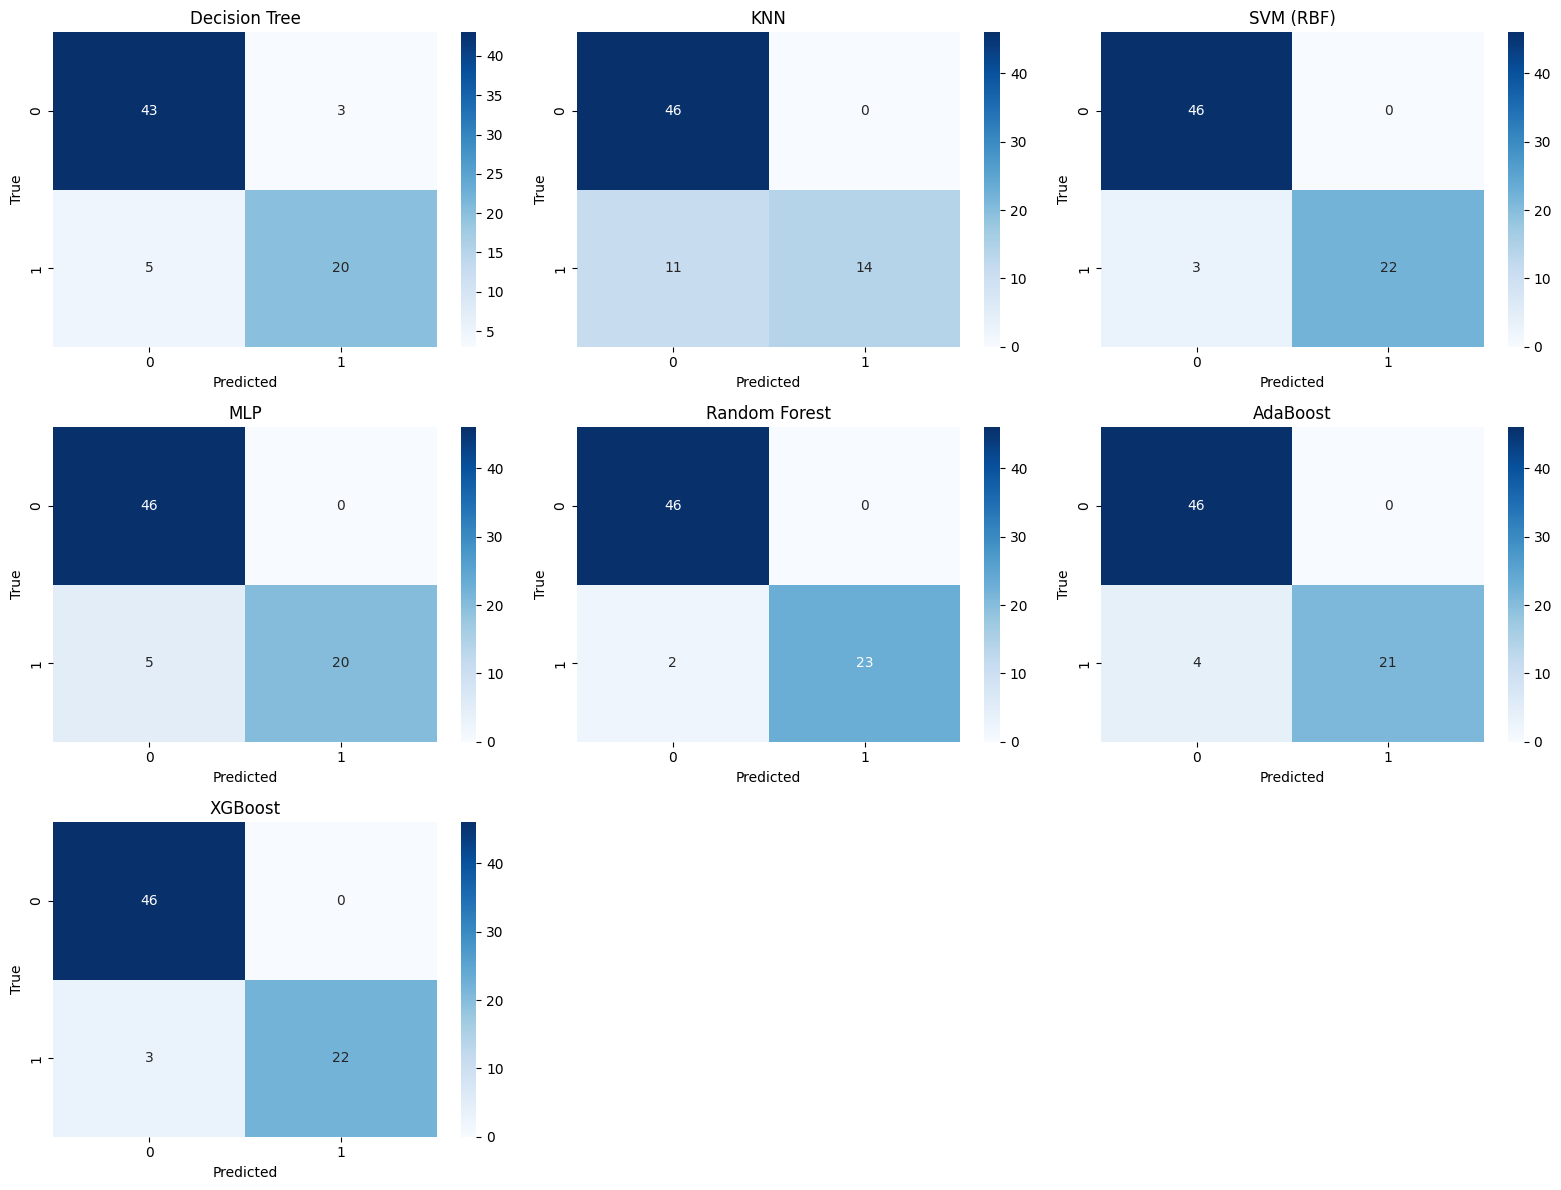

In [295]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(name)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")

# nascondi subplot vuoti
for j in range(len(conf_matrices), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

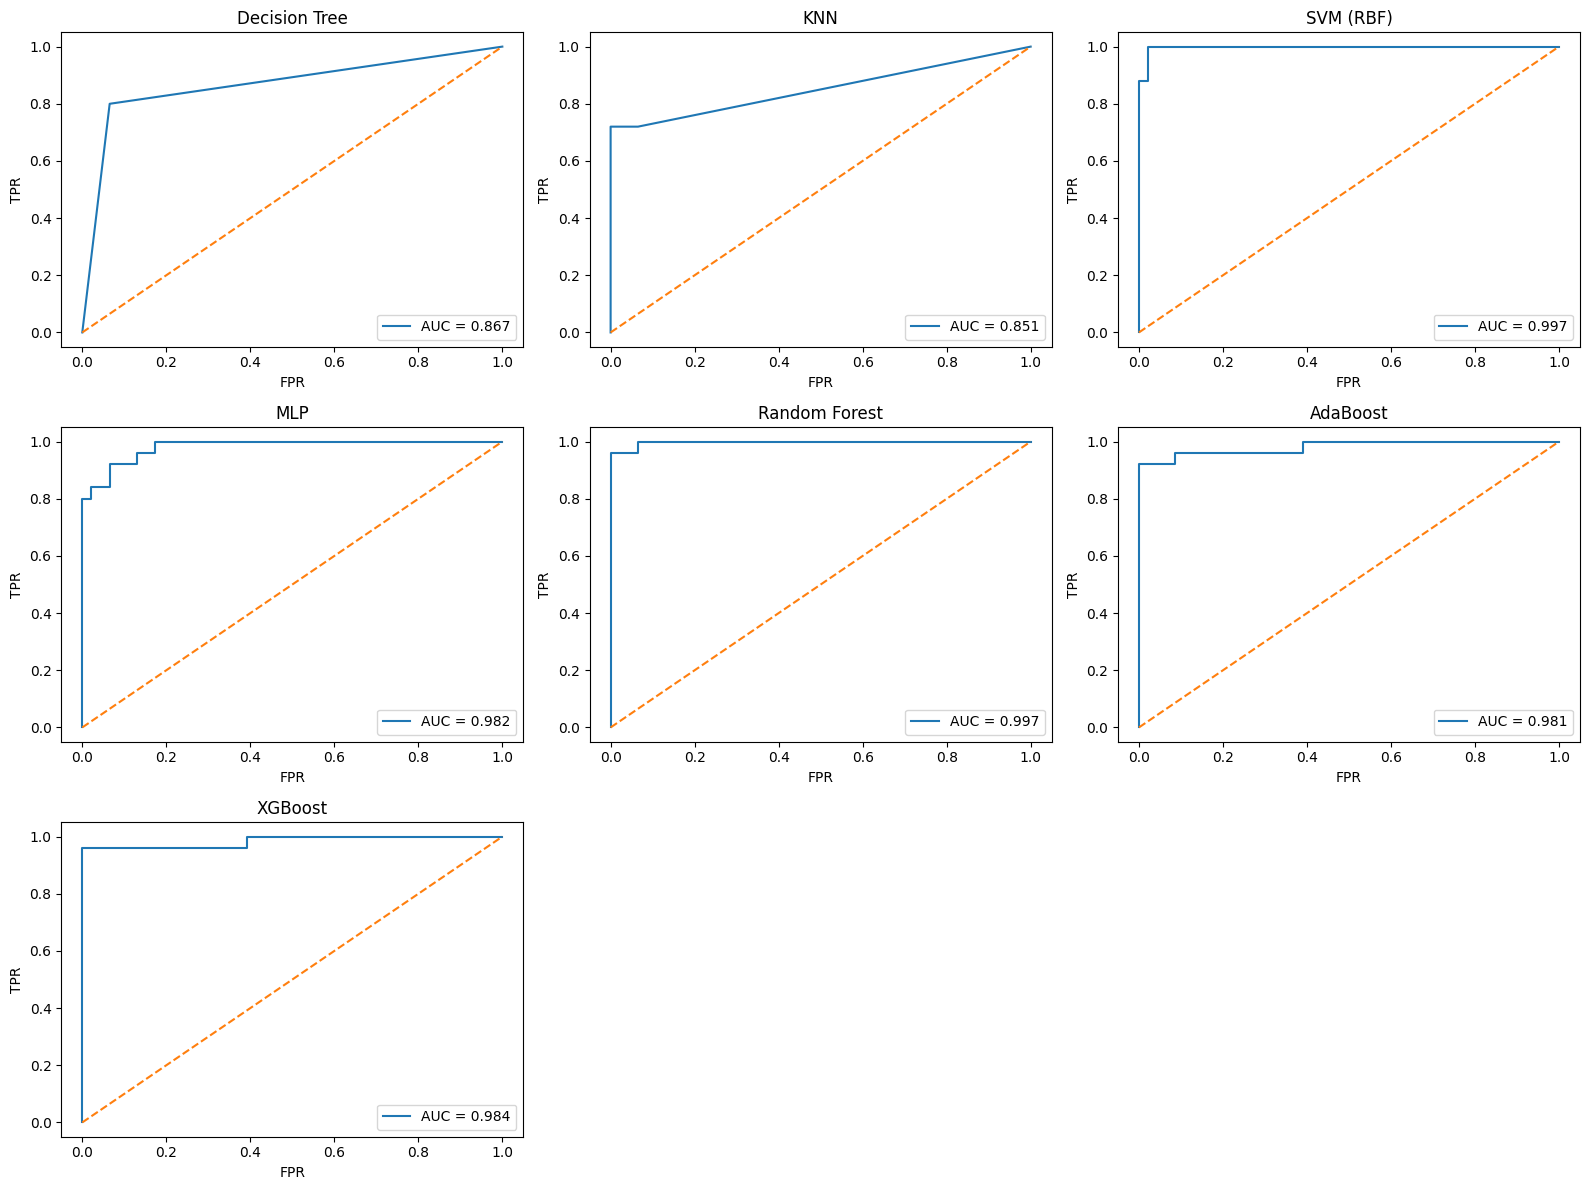

In [296]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    # prendo lo score continuo
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    else:
        # per modelli senza predict_proba (es. SVM senza probability=True)
        y_score = model.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=TARGET_LABEL)
    auc = roc_auc_score(y_test, y_score)

    ax = axes[i]
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle="--")  # baseline random
    ax.set_title(name)
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.legend(loc="lower right")

# nascondi subplot vuoti se hai meno di 9 modelli
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1400x700 with 0 Axes>

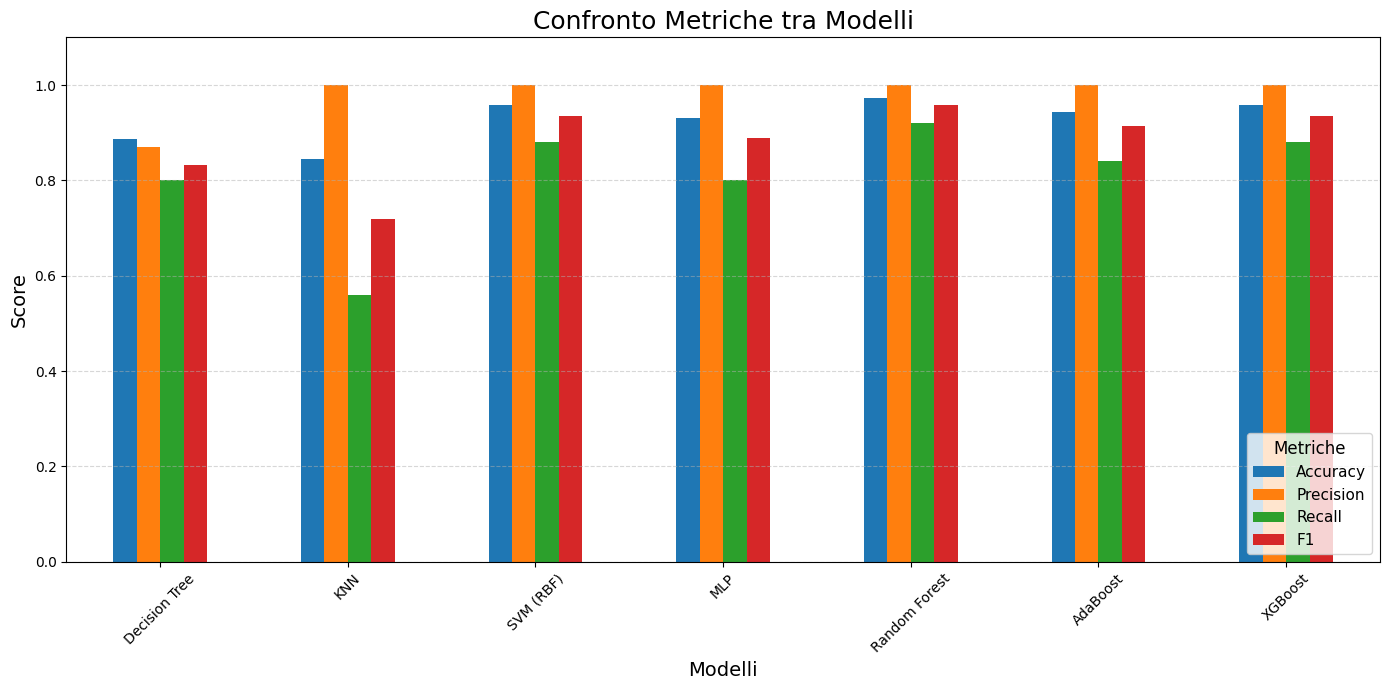

In [297]:
plt.figure(figsize=(14, 7))
df_results.plot(kind='bar', figsize=(14, 7), rot=45)

plt.title("Confronto Metriche tra Modelli", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Modelli", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.legend(title='Metriche', fontsize=11, title_fontsize=12, loc='lower right')

plt.tight_layout()
plt.show()

In [298]:
def train_eval_2d_models(
    models,                      # dict: {"AdaBoost": AdaBoostClassifier(...), "SVM": SVC(...), ...}
    X_train_2d, X_test_2d,
    y_train, y_test,
    feature_names_2d,
    strat_cv,
    task_type='binary',
    pos_label=1,
    do_plot=True
):
    """
    Esegue:
    - CV f1 per ciascun modello
    - fit finale
    - evaluate_model sul test
    - opzionale: plot 2D (una volta sola, non per ogni modello)
    Ritorna un dict con metrics + cv_scores.
    """
    results = {}

    # plot 2D unico (opzionale)
    if do_plot:
        plt.figure(figsize=(8,6))
        plt.scatter(
            X_train_2d[:, 0], X_train_2d[:, 1],
            c=y_train, cmap="coolwarm", alpha=0.7, edgecolor="k"
        )
        plt.xlabel(feature_names_2d[0] + " (Scaled)")
        plt.ylabel(feature_names_2d[1] + " (Scaled)")
        plt.title(f"Distribuzione classi 2D\n({feature_names_2d[0]} & {feature_names_2d[1]})")
        plt.colorbar(label="Classe")
        plt.show()

    for name, est in models.items():
        print(f"\n=== Modello: {name} ===")
        model = clone(est)

        cv_scores = cross_val_score(model, X_train_2d, y_train, cv=strat_cv, scoring='f1')
        cv_mean = cv_scores.mean()
        cv_std  = cv_scores.std()

        print(f"   >> Stratified CV F1: {cv_mean:.4f} (+/- {cv_std:.4f})")

        model.fit(X_train_2d, y_train)
        metrics = evaluate_model(model, X_test_2d, y_test, task_type, pos_label, False)

        print("   >> Metriche test:", metrics)

        results[name] = {
            "cv_scores": cv_scores,
            "cv_mean": cv_mean,
            "cv_std": cv_std,
            "metrics": metrics
        }

    return results

### PCA

In [299]:
# Per avere la F1 score uguale a quella originale (senza PCA) servono 12 componenti
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

print("Varianza spiegata:", pca.explained_variance_ratio_)

Varianza spiegata: [0.31385836 0.12357799]


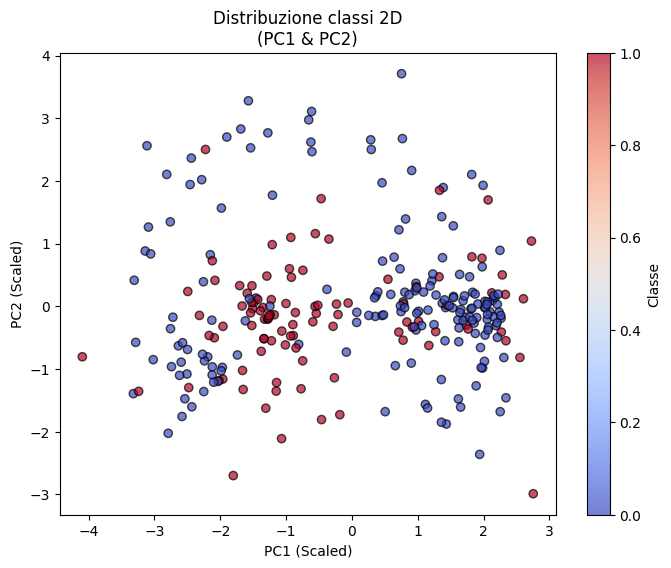


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.6914 (+/- 0.0282)
   >> Metriche test: {'Accuracy': 0.789, 'Precision': 0.727, 'Recall': 0.64, 'F1': 0.681}


In [300]:
models = {
    "Random Forest": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
}

results_pca = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_pca,
    X_test_2d=X_test_pca,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=["PC1", "PC2"],
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

### RECURSIVE FEATURE ELIMINATION (RFE)

In [301]:
feature_names = np.array(X_train_pd.columns)

rf_selector = RandomForestClassifier(random_state=42, n_jobs=-1)

rfe_ada = RFE(estimator=rf_selector, n_features_to_select=2, step=1)

X_train_rfe = rfe_ada.fit_transform(X_train, y_train)
X_test_rfe  = rfe_ada.transform(X_test)

print("Feature scelte:", feature_names[rfe_ada.support_])
print(f"Feature originali: {X_train.shape[1]}")
print(f"Feature rimaste: {X_train_rfe.shape[1]}")

Feature scelte: ['a03' 'a05']
Feature originali: 34
Feature rimaste: 2


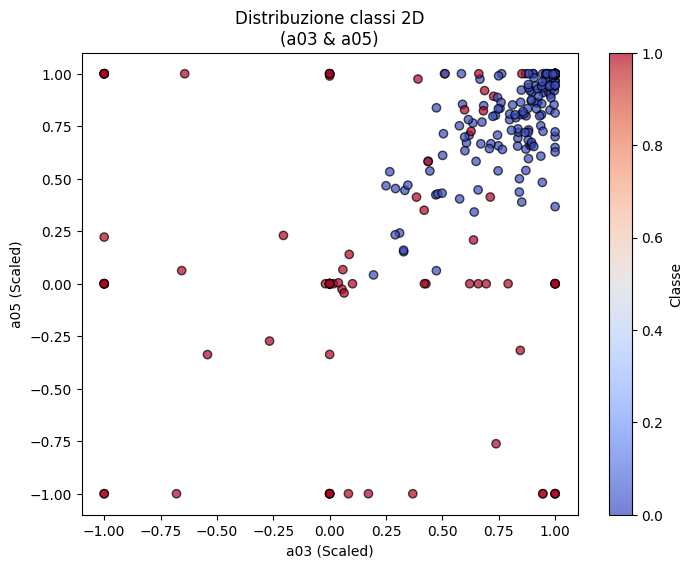


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.7932 (+/- 0.0484)
   >> Metriche test: {'Accuracy': 0.873, 'Precision': 0.944, 'Recall': 0.68, 'F1': 0.791}


In [302]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
}

results_rfe = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_rfe,
    X_test_2d=X_test_rfe,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names[rfe_ada.support_],
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

### FEATURE IMPORTANCE RANDOM FOREST

In [303]:
fi_selector = RandomForestClassifier(random_state=42, n_jobs=-1)
fi_selector.fit(X_train, y_train)

importances = fi_selector.feature_importances_
feature_names = np.array(X_train_pd.columns)

feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("--- Importanza feature (ordinale) ---")
print(feature_importance_df)

# 2) Selezione delle top 2 feature (indici + nomi)
top_k = 2
top_idx = np.argsort(importances)[::-1][:top_k]
top_names = feature_names[top_idx]

print(f"\n--- Top {top_k} feature per importance ---")
print(top_names)

# 3) Creazione dei dataset ridotti (solo le top 2)
X_train_fi = X_train[:, top_idx]
X_test_fi  = X_test[:, top_idx]


--- Importanza feature (ordinale) ---
   Feature  Importance
4      a05    0.126681
6      a07    0.099786
2      a03    0.097314
26     a27    0.090699
5      a06    0.041340
3      a04    0.041216
0      a01    0.040477
13     a14    0.038491
23     a24    0.031035
7      a08    0.030797
27     a28    0.030289
17     a18    0.029249
28     a29    0.027397
15     a16    0.026092
21     a22    0.023255
30     a31    0.020564
19     a20    0.017444
33     a34    0.015785
11     a12    0.015592
31     a32    0.014987
14     a15    0.014700
25     a26    0.013558
24     a25    0.013139
8      a09    0.013065
20     a21    0.011663
18     a19    0.011014
22     a23    0.010584
32     a33    0.010075
16     a17    0.009992
10     a11    0.009742
9      a10    0.009685
12     a13    0.007498
29     a30    0.006793
1      a02    0.000000

--- Top 2 feature per importance ---
['a05' 'a07']


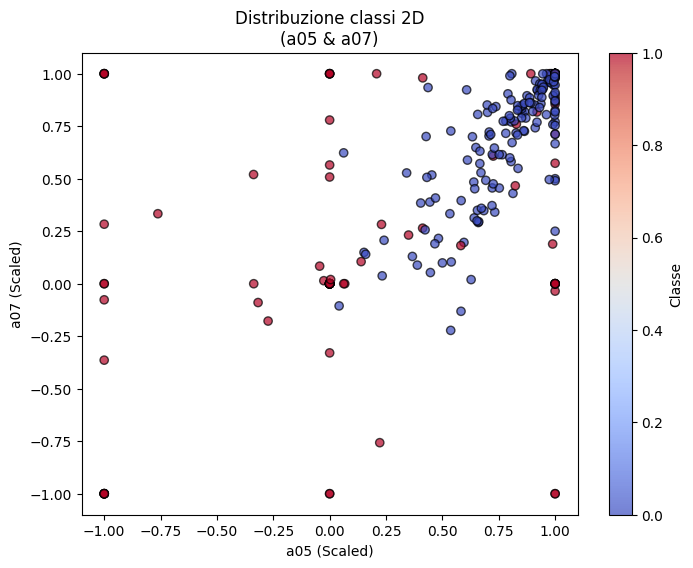


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.7348 (+/- 0.0557)
   >> Metriche test: {'Accuracy': 0.901, 'Precision': 0.95, 'Recall': 0.76, 'F1': 0.844}


In [304]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
}

results_fi = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_fi,
    X_test_2d=X_test_fi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names[top_idx],
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

### MUTUAL INFORMATION

In [305]:
mi = mutual_info_classif(X_train, y_train, random_state=RANDOM_STATE)

# 2) Ordino le feature per importanza MI
feature_names = np.array(feature_names)   
mi_df = pd.DataFrame({
    "Feature": feature_names,
    "MI": mi
}).sort_values(by="MI", ascending=False)

print(mi_df)

# 3) Prendo le top 2
feature_names = mi_df.head(2)["Feature"].values
indices = [list(feature_names).index(f) for f in feature_names]

print("Feature scelte:", feature_names)

# 4) Creo i dataset ridotti
X_train_mi = np.array(X_train_pd[feature_names])
X_test_mi  = np.array(X_test_pd[feature_names])

print(f"Feature originali: {X_train.shape[1]}")
print(f"Feature rimaste: {X_train_mi.shape[1]}")

   Feature        MI
2      a03  0.315487
5      a06  0.302554
4      a05  0.292155
7      a08  0.278182
26     a27  0.266595
20     a21  0.265251
32     a33  0.257667
28     a29  0.248657
22     a23  0.244789
13     a14  0.239070
30     a31  0.237543
33     a34  0.237311
6      a07  0.236108
23     a24  0.229472
21     a22  0.217676
31     a32  0.211833
24     a25  0.211449
12     a13  0.210226
14     a15  0.201645
3      a04  0.194423
15     a16  0.193378
11     a12  0.189745
27     a28  0.187256
9      a10  0.185979
10     a11  0.179766
17     a18  0.178396
8      a09  0.170772
19     a20  0.169890
25     a26  0.169126
16     a17  0.148183
29     a30  0.143609
18     a19  0.137692
0      a01  0.090244
1      a02  0.000000
Feature scelte: ['a03' 'a06']
Feature originali: 34
Feature rimaste: 2


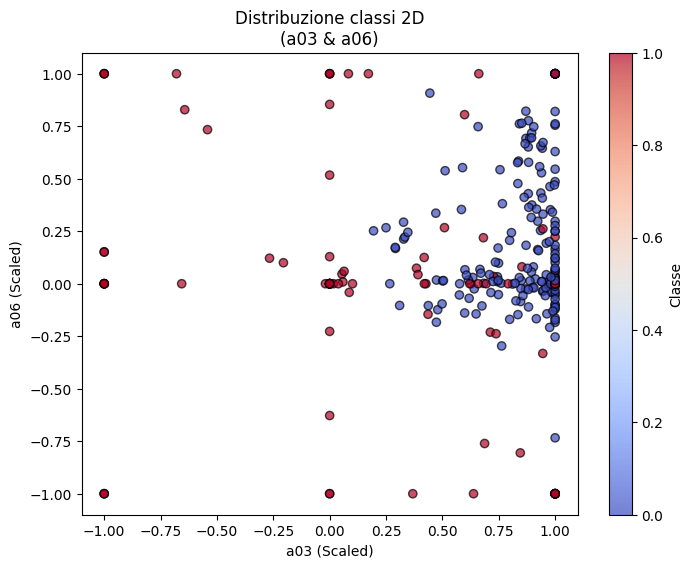


=== Modello: Random Forest ===
   >> Stratified CV F1: 0.8242 (+/- 0.0796)
   >> Metriche test: {'Accuracy': 0.873, 'Precision': 0.864, 'Recall': 0.76, 'F1': 0.809}


In [306]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1),
}

results_mi = train_eval_2d_models(
    models=models,
    X_train_2d=X_train_mi,
    X_test_2d=X_test_mi,
    y_train=y_train,
    y_test=y_test,
    feature_names_2d=feature_names,
    strat_cv=strat_cv,
    task_type='binary',
    pos_label=TARGET_LABEL,
    do_plot=True
)

In [307]:
df_compare = pd.DataFrame({
    "Original": df_results["F1"]["Random Forest"],
    "PCA": results_pca["Random Forest"]["metrics"]["F1"],
    "Feature Importance": results_fi["Random Forest"]["metrics"]["F1"],
    "RFE": results_rfe["Random Forest"]["metrics"]["F1"],
    "Mutual Information": results_mi["Random Forest"]["metrics"]["F1"],
}, index=["F1"])

df_compare


,Original,PCA,Feature Importance,RFE,Mutual Information
F1,0.958,0.681,0.844,0.791,0.809


<Figure size 1400x700 with 0 Axes>

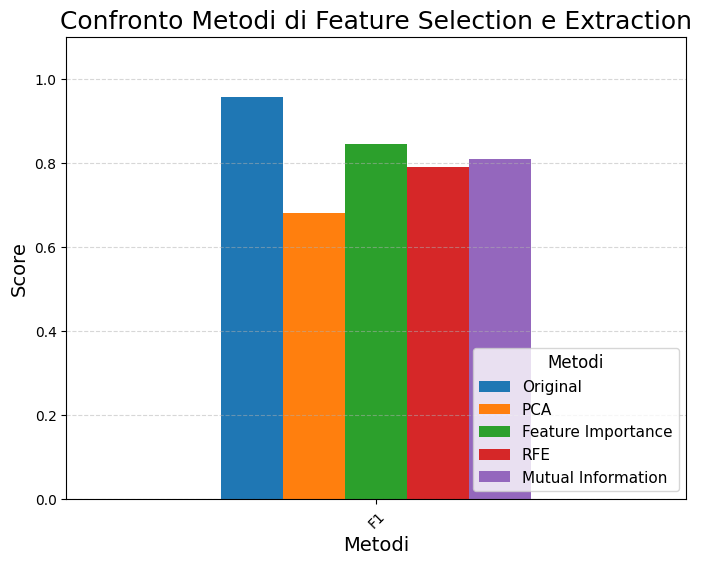

In [312]:
plt.figure(figsize=(14, 7))
df_compare.plot(kind='bar', rot=45, figsize=(8,6))
plt.title("Confronto Metodi di Feature Selection e Extraction", fontsize=18)
plt.ylabel("Score", fontsize=14)
plt.xlabel("Metodi", fontsize=14)
plt.ylim(0, 1.10)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='Metodi', fontsize=11, title_fontsize=12, loc='lower right')
plt.show()